# LOGO GENERATOR の学習

学習データに縦横のフリップ処理を追加して水増しを行う。

## import packages

In [0]:
import numpy as np
import pathlib
import pickle

from matplotlib import pyplot as plt
from PIL import Image
from google.colab import drive

## DCGAN のコードを取得

In [0]:
SOURCE_DIR = "logo_generator"

!cd /content
if (pathlib.Path(SOURCE_DIR).exists()):
    !rm -rf logo_generator
!git clone https://github.com/iimuz/logo_generator.git $SOURCE_DIR
%cd $SOURCE_DIR
!git checkout 17f646e

Cloning into 'logo_generator'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 40 (delta 16), reused 33 (delta 14), pack-reused 0
Unpacking objects: 100% (40/40), done.
/content/logo_generator
Note: checking out '17f646e'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 17f646e feat: Random に Horizontal と Vertical のフリップを加えたバージョン


## データ退避先の google drive をマウント

Google drive のパスにスペースが含まれており、後段で取り回しにくいので symlink で対応します。
以降では `LOG_DIR` にファイルが出力されます。

In [0]:
GDRIVE_DIR = pathlib.Path('/content/drive/My Drive/logo_generator')
LOG_DIR = pathlib.Path('logs')


def mount_gdrive(gdrive: pathlib.Path) -> None:
    if gdrive.exists() == False:
        drive.mount('/content/drive')
        !ln -s "$GDRIVE_DIR" $LOG_DIR

    !mkdir -p "$gdrive"


mount_gdrive(GDRIVE_DIR)

## トレーニングの実行

In [0]:
%run -i download_icons.py --full

parameters: Namespace(is_full=True, is_sample=False)
download from https://data.vision.ee.ethz.ch/sagea/lld/data/LLD-icon_full_data_PNG.zip to data/LLD-icon_full_data_PNG.zip
expand data from data/LLD-icon_full_data_PNG.zip to data/icons


In [0]:
%%writefile config.py
# 入力画像パラメータ
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
IMAGE_CHANNELS = 3

# 学習用パラメータ
BATCH_SIZE = 128
EPOCH_NUM = 25

LEARNING_RATE = 5e-6

# Generator 用パラメータ
Z_DIM = 62

# log 用パラメータ
LOG_DIR = "logs"
CHECKPOINT_EACH = 5
CHECKPOINT_IMAGES = 64

# リソース用パラメータ
USE_CUDA = True


Overwriting config.py


In [0]:
%run -i train.py --config config.py

parameters: {'IMAGE_WIDTH': 32, 'IMAGE_HEIGHT': 32, 'IMAGE_CHANNELS': 3, 'BATCH_SIZE': 128, 'EPOCH_NUM': 25, 'LEARNING_RATE': 5e-06, 'Z_DIM': 62, 'LOG_DIR': 'logs', 'CHECKPOINT_EACH': 5, 'CHECKPOINT_IMAGES': 64, 'USE_CUDA': True}
cuda state: True


epoch 24, d_loss: 0.005138, g_loss: 0.0117: 100%|██████████| 25/25 [1:09:48<00:00, 166.02s/it]


<Figure size 432x288 with 0 Axes>

## ログデータの表示

### Generator と Discriminator の loss プロット

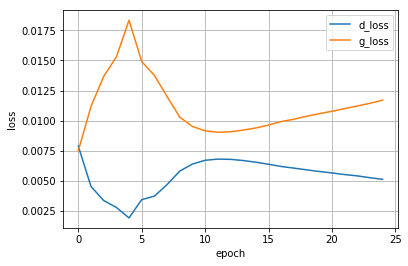

In [0]:
def plot_loss(log_dir: pathlib.Path):
    with open(log_dir.joinpath('history.pkl'), 'rb') as f:
        history = pickle.load(f)

    d_loss = [val['d_loss'] for val in history]
    g_loss = [val['g_loss'] for val in history]
    plt.plot(d_loss, label='d_loss')
    plt.plot(g_loss, label='g_loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()


plot_loss(log_dir=LOG_DIR)

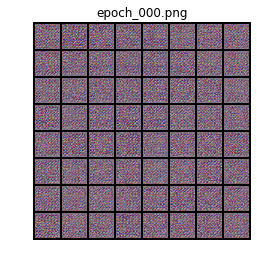

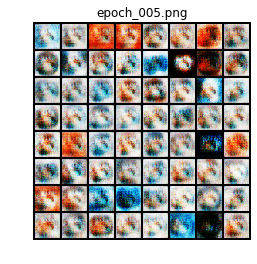

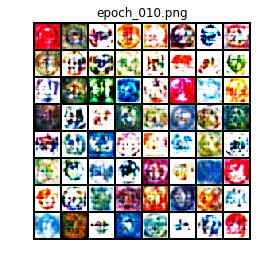

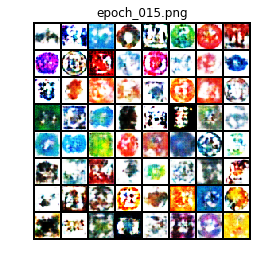

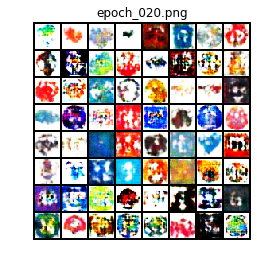

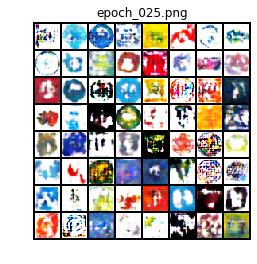

In [0]:
def show_checkpoint_images(log_dir: pathlib.Path) -> None:
    files = log_dir.glob('epoch_*.png')
    for file in files:
        plt.axis('off')
        plt.imshow(np.array(Image.open(file)))
        plt.title(str(file.name))
        plt.show()


show_checkpoint_images(log_dir=LOG_DIR)